This tutorial demonstrate how to train VQGAN in JAX/Flax using our pipeline. For the tutorial we will train on [imagenette](https://www.tensorflow.org/datasets/catalog/imagenette) datasets.

Note: This notebook will be re-evaluated when I get access to GPU to fully train this model, for now I am poor jobless person 😞.

In [ ]:
# Install dependencies
%pip install -r ../requirements.txt

# you can also create virtual environment and install dependencies with
%invoke venv # recommended

## 1. Imports

Import OmegaConf, LoadConfig, TrainerVQGan, DataLoader, TensorflowDataset. [OmegaConf](https://omegaconf.readthedocs.io/en/2.2_branch/#) is a library which will handle loading yaml file with our configs. Our pipeline is managed basically with yaml files specifying architecture, trainer, dataset loading and processing. LoadConfig is our dataclass config which will take omegaconf dict and prepare configs for training and data loading. TensorflowDataset and DataLoader are our objects for preparing datasets and creating something similar to PyTorch data loaders. Lastly TrainerVQGan is object which will take care of creating models, training them and logging.

In [1]:
# External libraries
# flake8: noqa: E402
import sys

from omegaconf import OmegaConf

# Internal libraries
sys.path.insert(0, "../")
from modules.config import LoadConfig
from modules.training import TrainerVQGan
from modules.utils import DataLoader, TensorflowDataset

/Users/vladimirzaigrajew/Documents/projects/jax-vqgan/myenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load configs
Now lets load our training configs. For now we created three sample configs located in `conf` folder:
- `config.yaml` my training config
- `imagenet.yaml` official training config for training on imagenet dataset
- `gumbel.yaml` official training config with Gumbel-max trick on imagenet dataset

You can create your own config if you want to but for this tutorial we will use `config.yaml`.

In [3]:
config_path = "../conf/config.yaml"
cfg_omega = OmegaConf.load(config_path)
print(OmegaConf.to_yaml(cfg_omega))

train:
  model_name: vqgan_imagenette
  model_hparams:
    embed_dim: 256
    n_embed: 1024
    double_z: false
    z_channels: 256
    in_channels: 3
    out_ch: 3
    ch: 128
    ch_mult:
    - 1
    - 1
    - 2
    - 2
    - 4
    act_name: gelu
    num_res_blocks: 2
    attn_resolutions:
    - 16
    dropout: 0.0
  disc_hparams:
    input_last_dim: 3
  save_dir: ../../datasets/vqgan_model_save
  log_dir: ../../datasets/vqgan_log_dir
  check_val_every_n_epoch: 1
  log_img_every_n_epoch: 5
  input_shape:
  - 256
  - 256
  - 3
  codebook_weight: 1.0
  monitor: total_loss
  recon_loss: l1
  disc_loss: hinge
  disc_weight: 0.8
  num_epochs: 10
  dtype: float32
  distributed: false
  seed: 42
  optimizer:
    _target_: optax.adamw
    learning_rate: 4.5e-06
    b1: 0.9
    b2: 0.999
    weight_decay: 0.0001
  optimizer_disc:
    _target_: optax.adamw
    learning_rate: 4.5e-06
    b1: 0.9
    b2: 0.999
    weight_decay: 0.0001
  disc_start: 7
  temp_scheduler: null
data:
  train_params:


We see that we have two sections `train` which corresponds to setting trainer and architectures and `data` specifying datasets, augmentation and preprocessing.

In [22]:
cfg_omega_dict = OmegaConf.to_container(cfg_omega)
cfg_omega_dict["train"]["num_epochs"] = 1  # reduce number of epochs for testing
cfg = LoadConfig(**cfg_omega)
print(cfg)

LoadConfig(train=TrainConfig(model_name='vqgan_imagenette', model_hparams=VQGANConfig {
  "act_name": "gelu",
  "attn_resolutions": [
    16
  ],
  "beta": 0.25,
  "ch": 128,
  "ch_mult": [
    1,
    1,
    2,
    2,
    4
  ],
  "double_z": false,
  "dropout": 0.0,
  "embed_dim": 256,
  "give_pre_end": false,
  "gumb_temp": 1.0,
  "in_channels": 3,
  "kl_weight": 0.0005,
  "n_embed": 1024,
  "num_res_blocks": 2,
  "num_resolutions": 5,
  "out_ch": 3,
  "resamp_with_conv": true,
  "resolution": 256,
  "transformers_version": "4.24.0",
  "use_gumbel": false,
  "z_channels": 256
}
, disc_hparams=DiscConfig {
  "input_last_dim": 3,
  "n_layers": 3,
  "ndf": 64,
  "output_last_dim": 1,
  "resolution": 256,
  "transformers_version": "4.24.0"
}
, save_dir='../../datasets/vqgan_model_save', log_dir='../../datasets/vqgan_log_dir', check_val_every_n_epoch=1, log_img_every_n_epoch=5, input_shape=(256, 256, 3), codebook_weight=1.0, monitor='total_loss', recon_loss='l1', disc_loss='hinge', disc_w

Now if you look more closely and compare two outputs you will see some inequalities, because `LoadConfig` does some preprocessing and instantiating some objects.

## 3. Prepare datasets and dataloaders
Having our train and data configs now lets create datasets and dataloaders.

In [23]:
print(cfg.data)

DataConfig(train_params=DataParams(batch_size=4, shuffle=True), test_params=DataParams(batch_size=8, shuffle=False), dataset_name='imagenette', dataset_root='../../datasets', transform={'__version__': '1.3.0', 'transform': {'__class_fullname__': 'Compose', 'additional_targets': {}, 'bbox_params': None, 'keypoint_params': None, 'p': 1.0, 'transforms': [{'__class_fullname__': 'RandomBrightnessContrast', 'always_apply': False, 'brightness_by_max': True, 'brightness_limit': [-0.1, 0.1], 'contrast_limit': [-0.2, 0.2], 'p': 0.5}, {'__class_fullname__': 'HorizontalFlip', 'always_apply': False, 'p': 0.5}]}}, size=256)


Config for data have information about train and test datasets, size of the images and augmentations which will be used with [albumentations]() frameworks

In [24]:
print(f"In train config we have information about data datatype. We use {cfg.train.dtype}")

dataset_train_class = TensorflowDataset(train=True, dtype=cfg.train.dtype, config=cfg.data)
dataset_test_class = TensorflowDataset(train=False, dtype=cfg.train.dtype, config=cfg.data)

In train config we have information about data datatype. We use <class 'jax.numpy.float32'>


Let`s look on data.

In [25]:
# Framework for visualization
from matplotlib import pyplot as plt

%matplotlib inline

from modules.utils import post_processing

In [26]:
dataset = dataset_test_class.get_dataset()
dataset_iter = iter(dataset)
data = next(dataset_iter)
print(f"Our data have shape: {data.shape} and data type: {data.dtype}")

Our data have shape: (256, 256, 3) and data type: <dtype: 'float32'>


2022-11-23 14:40:16.429179: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


We need to post process data because our data for modal is standardized and normalized.

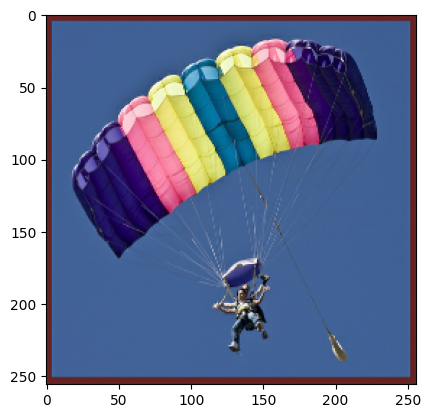

In [27]:
data_postprocessed = post_processing(data.numpy())
plt.imshow(data_postprocessed)
plt.show()

Now let's look at dataloader data

In [28]:
print(
    f"We use again information from train config about distributed training:{cfg.train.distributed}"
)
loader_train = DataLoader(dataset=dataset_train_class, distributed=cfg.train.distributed)
loader_val = DataLoader(dataset=dataset_test_class, distributed=cfg.train.distributed)

We use again information from train config about distributed training: False


In [29]:
dataloader_iter = iter(loader_val())
data = next(dataloader_iter)
print(f"Our data have shape: {data.shape} and data type: {data.dtype}")

Our data have shape: (8, 256, 256, 3) and data type: float32


2022-11-23 14:40:20.057526: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


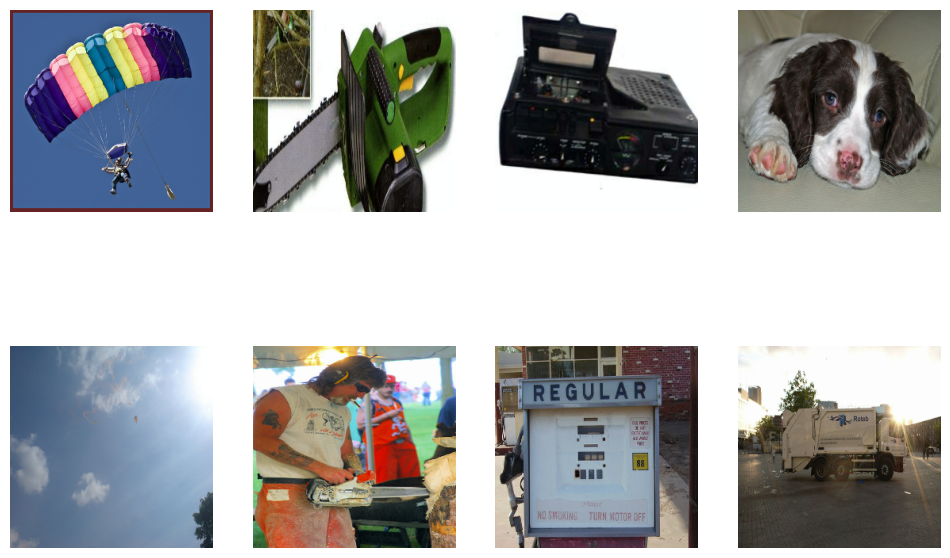

In [30]:
data = data[:8]
data_postprocessed = [post_processing(img) for img in data]
fig, axs = plt.subplots(2, 4, figsize=(12, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(data_postprocessed[i])
    ax.axis("off")
plt.show()

## 4. Prepare train module

You don't need to create architecture, inicialize it etc. Because for doing it we have our **trainer** `TrainerVQGan`. There we have prepared training, logging to Tensorboard and checkpointing it. Additionaly pmaping and jiting we also took care of it for you. THANK YOU 😤.

In [31]:
model = TrainerVQGan(module_config=cfg.train)

## 5 Let`s start trining ✊

In [ ]:
model.train_model(loader_train, loader_val)

## 6. What now we can do
You can now save model, but we always save model when we gat better results. You can also load model.

In [ ]:
if model.checkpoint_exists():
    model.load_model()

One can also see tensorboard results

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir cfg.train.log_dir --host localhost --port 8888

## 7. Lets look at the model
Now lets take the model and look at the samples

In [33]:
# external libraries
import jax
import numpy as np

# internal libraries
from modules.utils import make_img_grid

In [34]:
# Prepare data
dataloader_iter = iter(loader_val())
data = next(dataloader_iter)
data = data[:8]

2022-11-23 14:54:33.304669: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [36]:
# Generate images
reconst_imgs = model.model(data)[0]
reconst_imgs = jax.device_get(reconst_imgs)

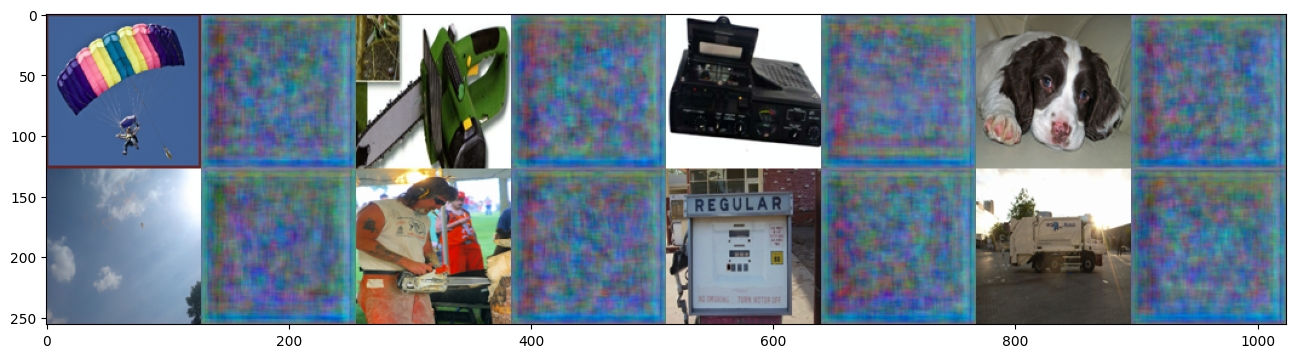

In [39]:
# Plot and add to tensorboard
imgs = np.stack([data, reconst_imgs], axis=1).reshape(-1, *data.shape[1:])
imgs = np.stack([post_processing(img, resize=128) for img in imgs], axis=0)
img_to_log = make_img_grid(imgs, nrows=2)
plt.figure(figsize=(16, 12))
plt.imshow(img_to_log)
plt.show()

Congrats 👏👏👏! You made it to the end of the trining example. You can revisit the same example, but structured differently as a couple of Python modules, test modules, config files, another Colab, and documentation in Git repo:

<https://github.com/WolodjaZ/jax-vqgan/blob/main/notebooks/example.ipynb>